#  📊 Динамика шахматного мастерства: Анализ и кластеризация пользователей Lichess ♕

## Введение
**Проект посвящен анализу и кластеризации игроков с сайта Lichess. Основная цель — понять, как различаются игроки по активности, рейтингу в различных режимах игры и игровым предпочтениям, а также выявить закономерности и поведение различных групп пользователей. Исследование выявляет ключевые группы игроков, их динамику развития и предпочтения в разных форматах шахмат, что поможет лучше понять структуру и закономерности игровой аудитории.**

## Сбор данных 

Для анализа мы собрали репрезентативную выборку игроков самого популярного формата на Lichess — blitz, так как именно этот временной контроль привлекает наибольшее количество участников и наиболее показателен для анализа. Для этого мы использовали недельное распределение рейтингов игроков в blitz, доступное на сайте Lichess (https://lichess.org/stat/rating/distribution/blitz), где участвуют 600-700 тысяч уникальных игроков еженедельно.

Мы распределили нашу выборку по рейтингу blitz с помощью рейтинговых бинов, что позволило создать распределение из примерно 35 000 игроков, близкое к общему на Lichess:

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sample_df = pd.read_csv('sample_df.csv')

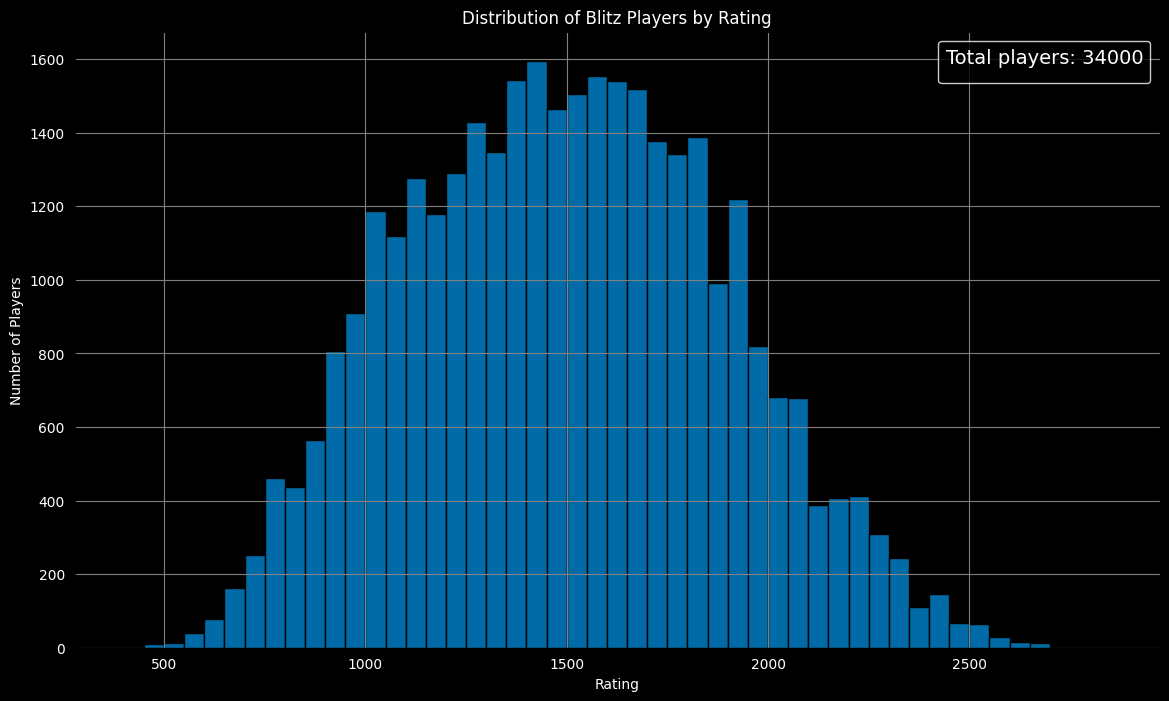

In [2]:
ratings = sample_df['blitz_rating']

# Построение гистограммы распределения игроков по рейтингам
plt.figure(figsize=(14,8))
plt.gca().set_facecolor('black')
plt.gcf().set_facecolor('black')

plt.hist(ratings, bins=range(int(min(ratings)), int(max(ratings)) + 50, 50), 
         color='#006ba6', edgecolor='black')  

plt.title('Distribution of Blitz Players by Rating', color='white')
plt.xlabel('Rating', color='white')
plt.ylabel('Number of Players', color='white')
legend = plt.legend(title="Total players: {}".format(len(ratings)), fontsize=13, title_fontsize='14', facecolor='black', edgecolor='white')
legend.get_title().set_color('white')  

plt.grid(True, color='gray')  
for label in (plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
    label.set_color('white') 

plt.show()

Код для получения выборки по API вы сможете найти в первой части проекта.



  *Весь далнейший анализ и кластерицация будет проводится в контексте пользователей, сыгравших минимум одну игру формата blitz.

## Анализ данных 🔍

Чтобы оценить, насколько наша выборка отражает общий уровень мастерства игроков, построим графики по другим режимам игры — bullet, puzzle, rapid и classical — **по тем же игрокам**. Для того чтобы учесть систему отклонения рейтингов (rating deviation) и рейтинги более точным образом отражали уровень игры игроков, будем строить графики по игрокам с количеством игр > 30 по соответствующим режимам игры.

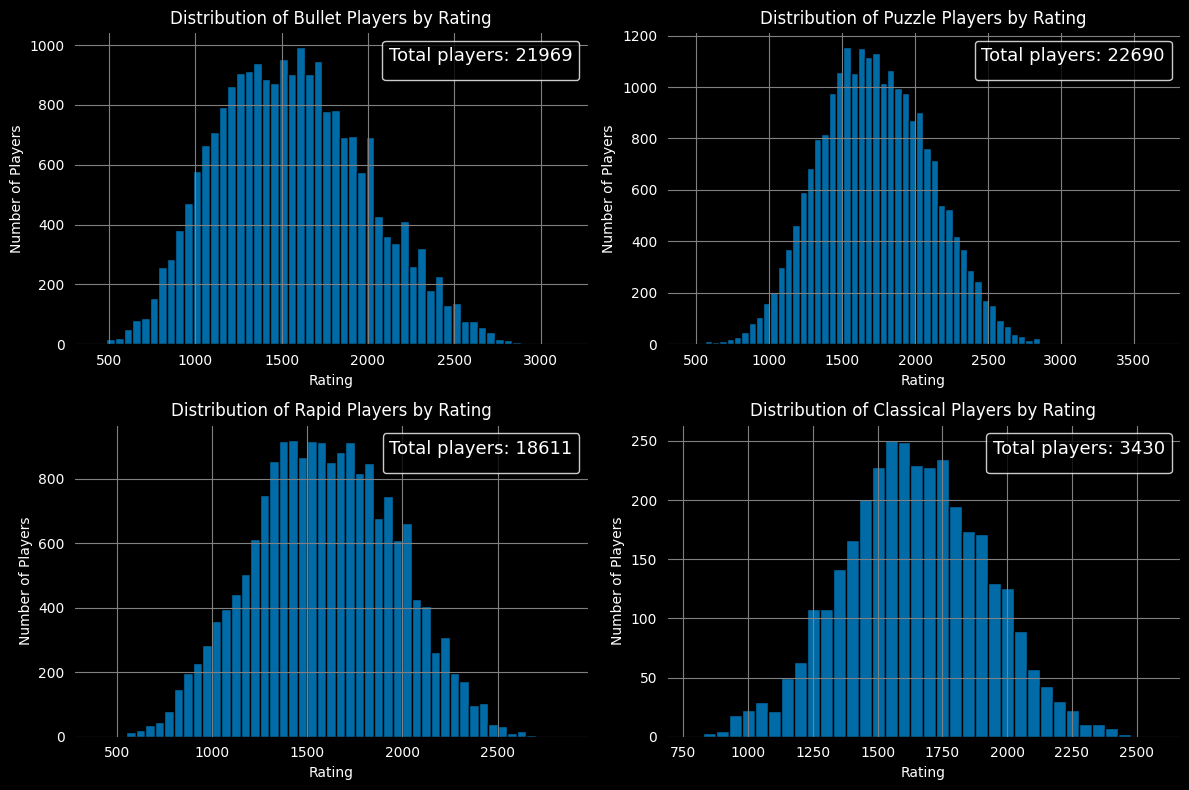

In [3]:
rating_types = ['bullet_rating', 'puzzle_rating', 'rapid_rating', 'classical_rating']

# Создаем фигуру и оси для 2x2 сетки
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.patch.set_facecolor('black')  # Устанавливаем черный фон для всей фигуры

# Преобразуем сетку осей в плоский список, чтобы легче было обращаться
axes = axes.flatten()

for i, rating_type in enumerate(rating_types):
    # игр > 30
    ratings = sample_df[sample_df['{}'.format(rating_type.split('_')[0] + '_games')] > 30][rating_type]
    
    ax = axes[i]  # Получаем текущую ось
    ax.set_facecolor('black')
    
    ax.hist(ratings, bins=range(int(min(ratings)), int(max(ratings)) + 50, 50), color='#006ba6', edgecolor='black')
    
    ax.set_title('Distribution of {} Players by Rating'.format(rating_type.split('_')[0].capitalize()), color='white')
    ax.set_xlabel('Rating', color='white')
    ax.set_ylabel('Number of Players', color='white')
    ax.grid(True, color='gray') 
    
    legend = ax.legend(title="Total players: {}".format(len(ratings)), fontsize=12, title_fontsize='13', facecolor='black', edgecolor='white')
    for text in legend.get_texts():
        text.set_color('white')  
    legend.get_title().set_color('white') 
    
    # Устанавливаем цвет текста меток осей на белый
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_color('white')

# Уменьшаем расстояние между графиками для более компактного отображения
plt.tight_layout()
plt.show()

- По графикам можно увидеть, что распределения по другим режимам игры оказались довольно симметричными и близкими к нормальному распределению. Что позволяет предположить, что наша выборка не только репрезентативна для анализа в режиме blitz, но и отражает общее распределение уровня мастерства игроков.

Немногие пользователи указываеют страну и флаг в профиле. По таким пользователям, из любопытства, построим распределение рейтинга по топ-5 странам и выведем топ-10 стран по количеству игроков.

In [4]:
sample_df.flag.value_counts()[:10]

flag
RU    1015
IN     594
US     480
DE     435
TR     400
BR     265
FR     241
AR     199
IT     196
UA     189
Name: count, dtype: int64

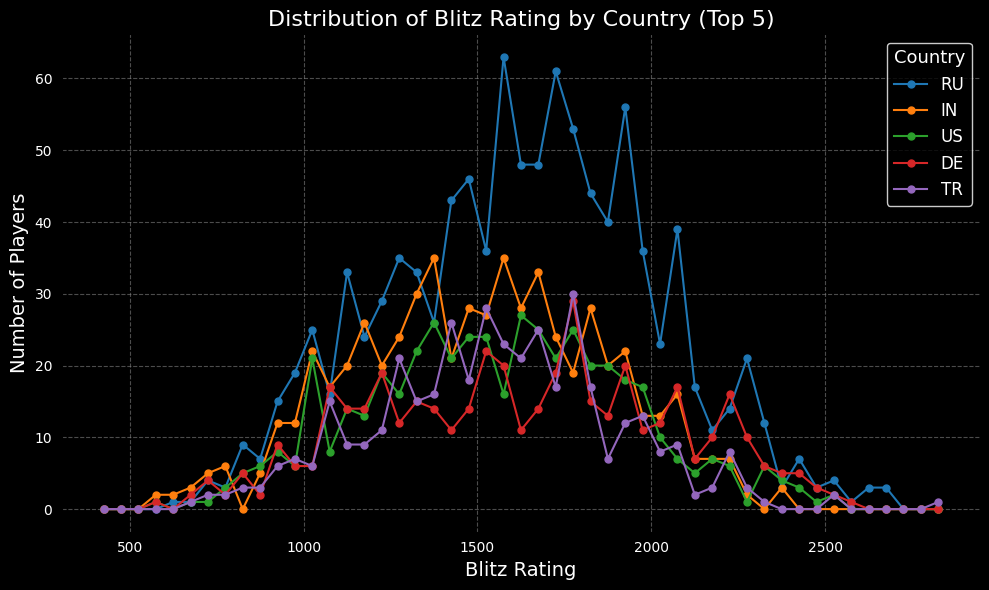

In [5]:
# Группируем данные по странам и считаем количество игроков в каждой стране
country_counts = sample_df['flag'].value_counts().head(5)
top_5_countries = country_counts.index

plt.figure(figsize=(10, 6))

plt.gca().set_facecolor('black')
plt.gcf().set_facecolor('black') 

# Строим графики для каждой из топ-5 стран
for country in top_5_countries:
    country_data = sample_df[sample_df['flag'] == country]
    
    # Строим распределение для страны (гистограмма без столбцов, сглаживание через линию)
    counts, bins = np.histogram(country_data['blitz_rating'], bins=range(int(min(sample_df['blitz_rating'])), int(max(sample_df['blitz_rating'])) + 50, 50))
    
    # Центрируем бины для более точного отображения
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Строим линию для каждой страны
    plt.plot(bin_centers, counts, label=country, marker='o', linestyle='-', markersize=5)

plt.title('Distribution of Blitz Rating by Country (Top 5)', fontsize=16, color='white')
plt.xlabel('Blitz Rating', fontsize=14, color='white')
plt.ylabel('Number of Players', fontsize=14, color='white')
plt.grid(True, linestyle='--', alpha=0.6, color='gray')  

legend = plt.legend(title="Country", fontsize=12, title_fontsize='13', facecolor='black', edgecolor='white')
for text in legend.get_texts():
    text.set_color('white') 
legend.get_title().set_color('white')  

for label in (plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
    label.set_color('white')

plt.tight_layout()
plt.show()

- Для выводов по распределению игроков по странам такой выборки, конечно, недостаточно. К тому же только примерно четверть пользователей указала флаг в профиле. Однако, видеть данные страны в списке - не сюрприз.

### Корреляционный анализ

В этом разделе мы вычислим корреляции между рейтингами игроков в различных режимах игры: blitz, bullet, rapid, classical, puzzle и racer. Это позволяет понять, насколько сильно различаются или схожи уровни мастерства игроков между этими режимами.



1. **Расчет корреляций**: Мы создали матрицу корреляций, где для каждой пары режимов игры рассчитали коэффициент корреляции Пирсона между их рейтингами для тех игроков, которые сыграли более 30 партий в каждом из анализируемых режимов (чтобы учесть rating deviation). Это помогает выявить, насколько успех в одном режиме (например, blitz) соотносится c успехом в другом режиме (например, rapid).

2. **Тепловая карта корреляций**: Результаты корреляционного анализа визуализированы с помощью тепловой карты, где более насыщенные цвета отражают более сильные корреляции (положительные или отрицательные).

3. **Scatter plot парных корреляций**: Дополнительно для каждой пары рейтингов были построены scatter plots, которые наглядно демонстрируют взаимосвязь рейтингов между различными типами игры.



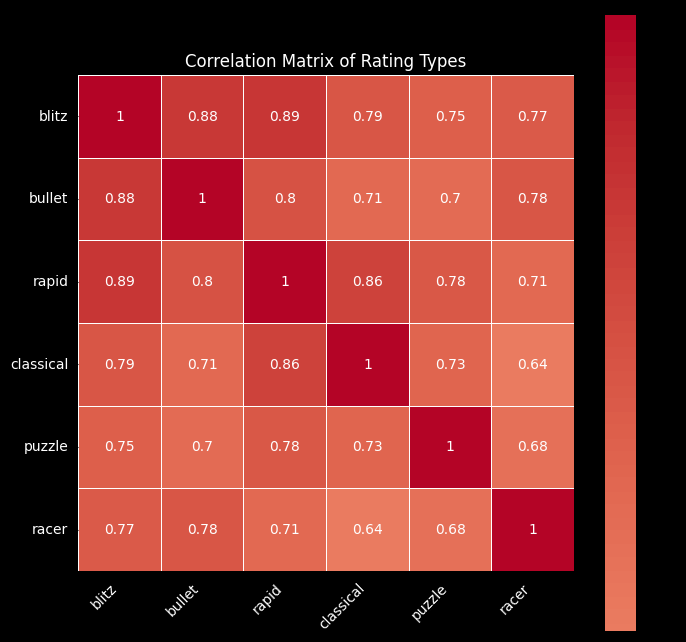

In [6]:
# Переименование колонок: Для удобства работы с данными мы переименовали колонки, заменив racer_runs 
# на racer_games, а racer_score на racer_rating.
sample_df.rename(columns={'racer_runs': 'racer_games', 'racer_score': 'racer_rating'}, inplace=True)

game_types = ['blitz', 'bullet', 'rapid', 'classical', 'puzzle', 'racer']

# пустой DataFrame для хранения корреляций
corr_matrix = pd.DataFrame(np.zeros((len(game_types), len(game_types))), index=game_types, columns=game_types)

# Вычисляем корреляции между типами игр
for type1 in range(len(game_types) - 1):
    for type2 in range(type1 + 1, len(game_types)):
        corr_value = sample_df[(sample_df[f'{game_types[type1]}_games'] > 30) & 
                               (sample_df[f'{game_types[type2]}_games'] > 30)] \
                               [[f'{game_types[type1]}_rating', f'{game_types[type2]}_rating']].corr().iloc[0, 1]
        # Записываем в таблицу симметрично
        corr_matrix.loc[game_types[type1], game_types[type2]] = corr_value
        corr_matrix.loc[game_types[type2], game_types[type1]] = corr_value

# Устанавливаем 1 на главной диагонали
np.fill_diagonal(corr_matrix.values, 1)

# Построение тепловой карты
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5, cbar=True, square=True, 
            annot_kws={'color': 'white'}, xticklabels=game_types, yticklabels=game_types)

plt.xticks(rotation=45, ha='right', color='white')
plt.yticks(rotation=0, color='white')
plt.title('Correlation Matrix of Rating Types', color='white')

plt.gca().set_facecolor('black')
plt.gcf().set_facecolor('black')

plt.show()

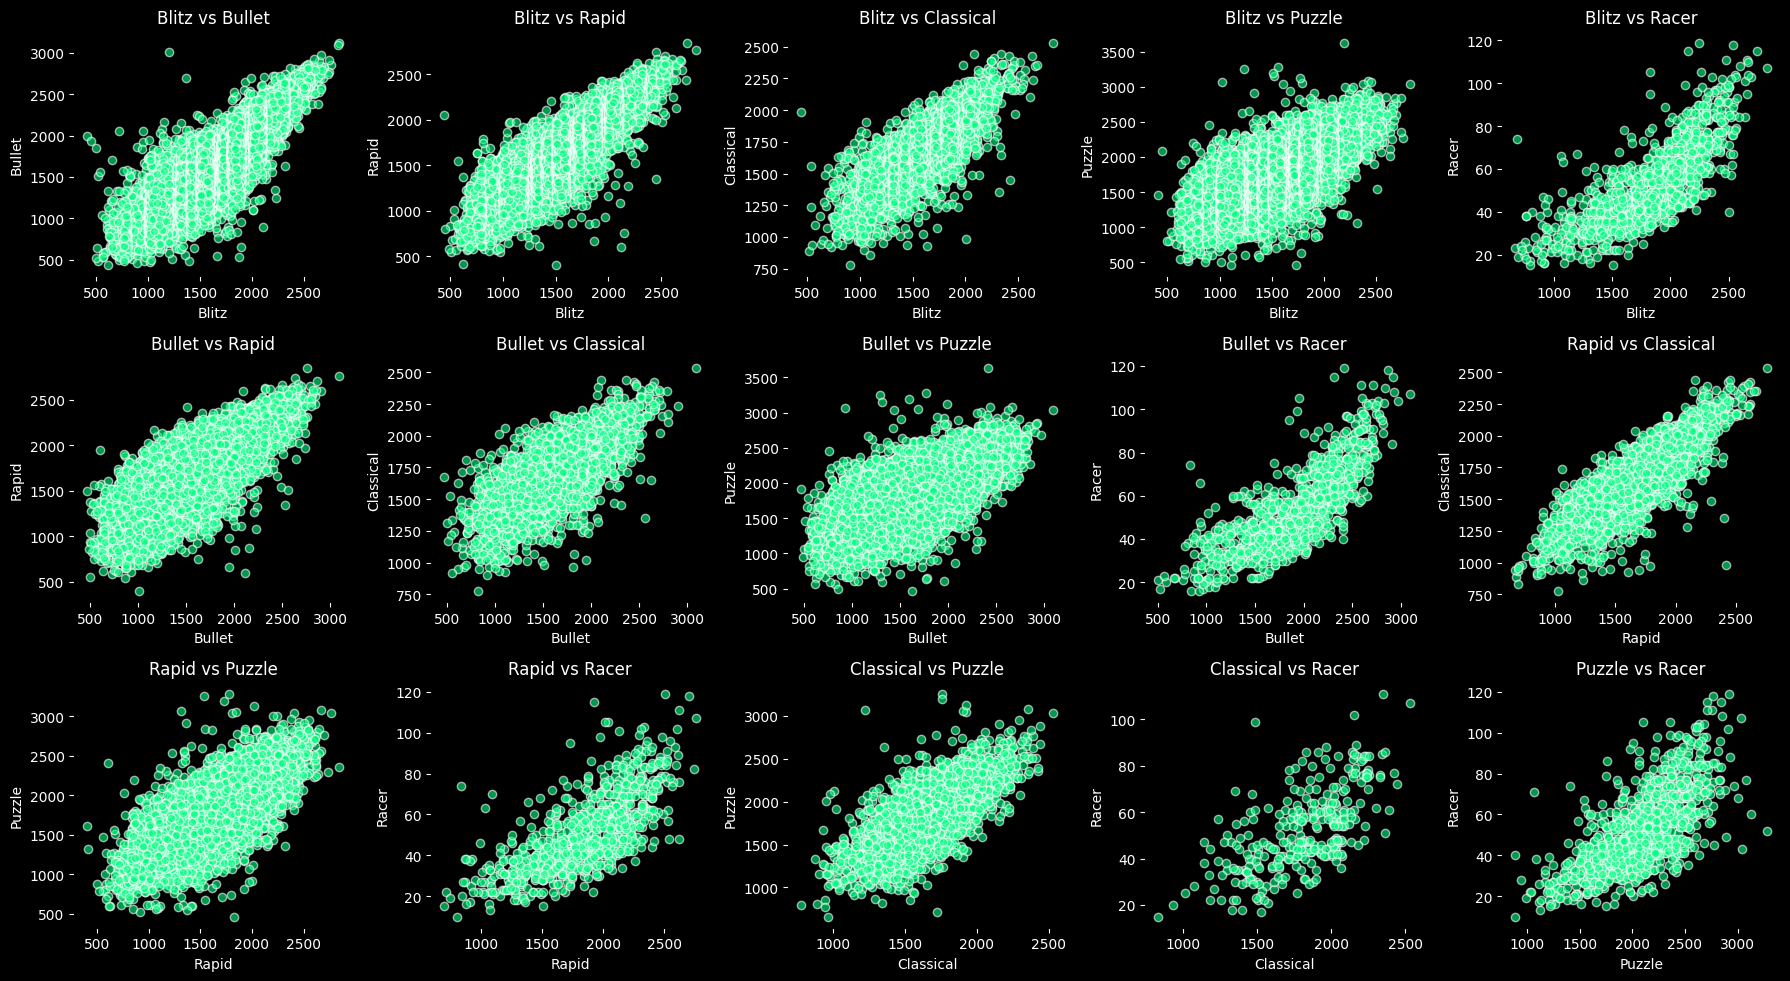

In [7]:
import matplotlib.pyplot as plt

# Задаем количество строк и столбцов для сетки графиков
fig, axes = plt.subplots(5, 5, figsize=(18, 16))

# Преобразуем массив осей в плоский список для удобства обращения
axes = axes.flatten()

# Счетчик для осей
count = 0

# Создаем scatter plots для каждой пары рейтингов
for type1 in range(len(game_types) - 1):
    for type2 in range(type1 + 1, len(game_types)):
        # Фильтруем данные по играм > 30 для обоих типов
        filtered_df = sample_df[(sample_df[f'{game_types[type1]}_games'] > 30) & 
                                (sample_df[f'{game_types[type2]}_games'] > 30)]
        
        # Получаем текущую ось
        ax = axes[count]
        
        # Строим scatter plot
        ax.scatter(filtered_df[f'{game_types[type1]}_rating'], 
                   filtered_df[f'{game_types[type2]}_rating'], 
                   color='#00ff7f', edgecolor='white', alpha=0.6)
        
        ax.set_facecolor('black')
        
        ax.set_title(f'{game_types[type1].capitalize()} vs {game_types[type2].capitalize()}', color='white')
        ax.set_xlabel(f'{game_types[type1].capitalize()}', color='white')
        ax.set_ylabel(f'{game_types[type2].capitalize()}', color='white')

        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')

        count += 1

# Отключаем ненужные оси
for i in range(count, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
# Устанавливаем черный фон для всей фигуры
plt.gcf().set_facecolor('black')

plt.show()

### Вывод по корреляционному анализу:
На основе представленной тепловой карты можно сделать следующие выводы:

- Высокая корреляция между Blitz и Bullet, Blitz и Rapid:
Наибольшие значения корреляции наблюдаются между рейтингами в blitz и rapid - 0,89 и blitz и bullet - 0.88. Это говорит о том, что игроки, показывающие высокий уровень в blitz, с большой вероятностью будут иметь схожие успехи в bullet и rapid. Данные корреляции можно обьяснить относительно схожими контролями по времени на партию (например 1 минута в bullet и 3 в blitz, или 5 минут в blitz и 10 в rapid).

- Classical и Rapid:
Корреляция между classical и rapid рейтингами также высокая — 0.86, что вполне ожидаемо, поскольку оба режима требуют более длительного времени на партию и стратегического мышления, нежели быстрые партии, такие как bullet или blitz.

- Тактические задачи Puzzle:
Решение задач puzzle без ограничения по времени лучше всего коррелирует со средним временным контролем rapid - 0.78 и чуть хуже с blitz - 0.75.

- Тактические задачи на время Puzzle_Racer:
Неплохо коррелирует с blitz и bullet (0,77 и 0,78), что вполне ожидаемо и может объясняться скоростью принятия решений.
Самая низкая корреляция отмечается между classical и racer рейтингами — 0.64, что подчеркивает различие в динамике этих режимов.

## Кластеризация 🌀
В этом разделе мы проведем кластеризацию игроков на основе их рейтингов, количесву партий в разных типах игры, общему времени игры, а также времени с момента регистрации на сайте. Мы используем этот набор признаков, чтобы классифицировать игроков по схожести. Для кластеризации применяются следующие шаги:
- Подготовка данных
- Определение оптимального числа кластеров с помощью коэффициентов силуэта и иерархической кластеризации
- Инициализация случайных центроидов
- Обновление меток кластеров
- Обновление центроидов
- Визуализация кластеров
- Интерпретация результатов

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from IPython.display import clear_output
from datetime import datetime

### 1. Подготовка и очистка данных
Cоздаем новые колонки с игровым временем в днях и количеством дней с момента регистрации.
Заполняем пропуски в данных, где это необходимо.
Нормализуем данные для корректного выполнения кластеризации.

In [9]:
sample_df['play_time_total_days'] = sample_df['play_time_total'] / (60 * 60 * 24)
current_timestamp = int(datetime.now().timestamp() * 1000) # текущий момент в миллисекундах
sample_df['days_registered'] = (current_timestamp - sample_df['createdAt']) / (1000 * 60 * 60 * 24)  # перевод в дн

In [10]:
sample_df.isna().sum()

blitz_games                 0
blitz_prog                  0
blitz_rating                0
blitz_rd                    0
bullet_games                0
bullet_rating               0
bullet_rd                   0
classical_games             0
classical_rating            0
classical_rd                0
createdAt                   0
flag                    25555
play_time_total            36
play_time_tv               36
puzzle_games             5164
puzzle_rating            5164
puzzle_rd                5164
racer_games             28874
racer_rating            28874
rapid_games                 0
rapid_rating                0
rapid_rd                    0
username                    0
bin                         0
play_time_total_days       36
days_registered             0
dtype: int64

In [11]:
# Нас интересуют пропущенные значения в play_time_total_days, которые мы сбросим, а также заменим 
# NA в puzzle_games на 0
sample_df = sample_df.dropna(subset=['play_time_total_days'])
sample_df['puzzle_games'] = sample_df['puzzle_games'].fillna(0)

# Признаки, по которым производится кластеризация
features = ['blitz_rating', 'blitz_games', 'play_time_total_days', 
            'days_registered', 'bullet_games', 'puzzle_games', 'rapid_games', 'classical_games']

# Нормализуем данные по шкале [1, 10]
data = sample_df[features].copy()
data = ((data - data.min()) / (data.max() - data.min())) * 9 + 1

In [12]:
data.describe()

blitz_rating   blitz_games  play_time_total_days  days_registered  \
count  33964.000000  33964.000000          33964.000000     33964.000000   
mean       5.038656      1.314278              1.370943         3.070068   
std        1.445736      0.512895              0.499437         1.557986   
min        1.000000      1.000000              1.000000         1.000000   
25%        3.945990      1.023717              1.058987         1.718096   
50%        5.028642      1.122220              1.195755         2.925371   
75%        6.078151      1.382645              1.487860         3.954559   
max       10.000000     10.000000             10.000000        10.000000   

       bullet_games  puzzle_games   rapid_games  classical_games  
count  33964.000000  33964.000000  33964.000000     33964.000000  
mean       1.134524      1.050989      1.067868         1.014719  
std        0.391713      0.181616      0.226565         0.126769  
min        1.000000      1.000000      1.000000         1.000000  
25%        1.000240      1.000401      1.000336         1.000000  
50%        1.005811      1.004955      1.005377         1.000000  
75%        1.075297      1.033703      1.042010         1.001849  
max       10.000000     10.000000     10.000000        10.000000

### 2. Определение оптимального числа кластеров с помощью коэффициентов силуэта и иерархической кластеризации

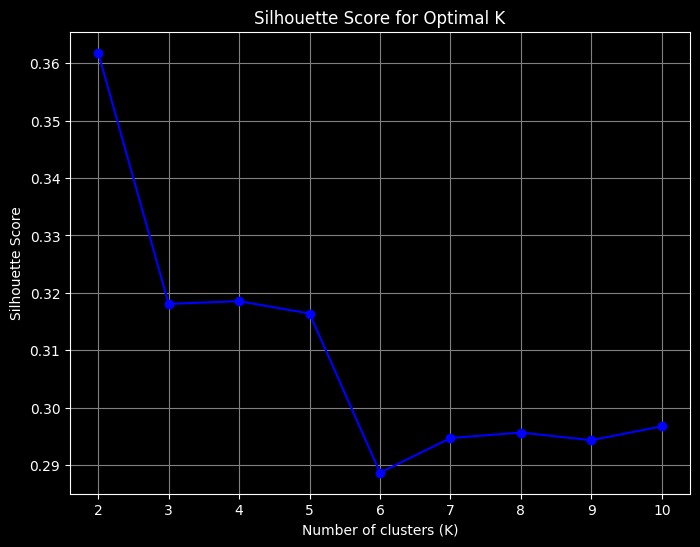

In [13]:
K_range = range(1, 11)
# Рассчитываем силуэтные коэффициенты для каждого значения K
silhouette_scores = []
for k in K_range[1:]:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=1)
    labels = kmeans.fit_predict(data)
    silhouette_scores.append(silhouette_score(data, labels))

# Строим график силуэтных коэффициентов
plt.style.use('dark_background')
plt.figure(figsize=(8, 6))
plt.plot(K_range[1:], silhouette_scores, 'bo-')
plt.xlabel('Number of clusters (K)', color='white')
plt.ylabel('Silhouette Score', color='white')
plt.title('Silhouette Score for Optimal K', color='white')
plt.grid(True, color='gray')  
plt.xticks(color='white')  
plt.yticks(color='white') 
plt.show()

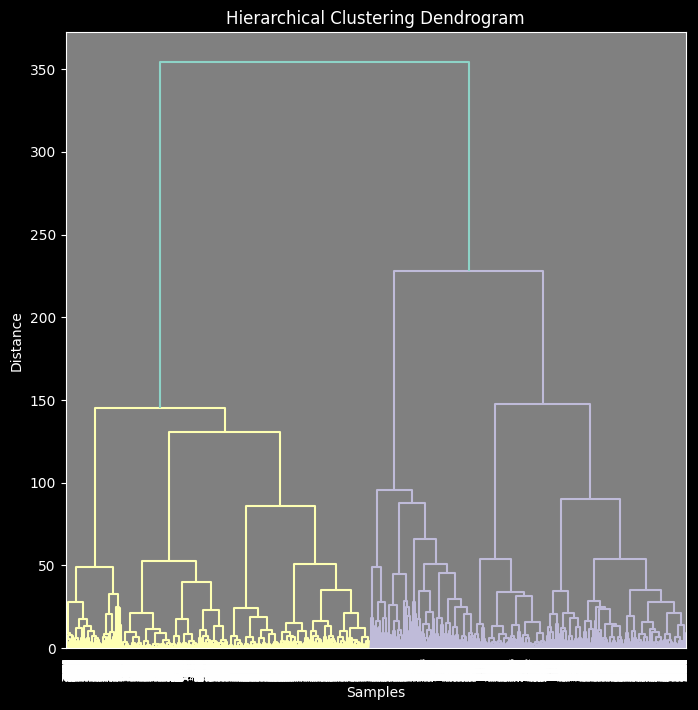

In [14]:
# Построение агломеративной кластеризации
Z = linkage(data, method='ward')

# Устанавливаем стиль графика
plt.style.use('dark_background')

# Построение дендрограммы
plt.figure(figsize=(8, 8))
dendrogram(Z)  
plt.title('Hierarchical Clustering Dendrogram', color='white')
plt.xlabel('Samples', color='white')
plt.ylabel('Distance', color='white')
plt.tick_params(axis='x', colors='white') 
plt.tick_params(axis='y', colors='white') 
plt.grid(True, color='gray') 
plt.show()

- Выбор 5 кластеров кажется оправданным, так как структура дендрограммы четко демонстрирует крупные ветви, соответствующие этому количеству кластеров. По графику силуэтных коэффициентов значение для 5 кластеров ниже, чем для 2 кластеров, однако оно все еще остается в допустимом диапазоне и значительно выше, чем для 6 или более кластеров. 

### 3. Инициализация случайных центроидов:

In [15]:
def random_centroids(data, k):
    centroids = []
    for i in range(k):
        centroid = data.apply(lambda x: float(x.sample()))
        centroids.append(centroid)
    return pd.concat(centroids, axis=1)

### 4. Обновление меток кластеров
Для каждой итерации обновляем метки кластеров, присваивая каждую запись кластеру, центроид которого находится к ней ближе всего.

In [16]:
def get_labels(data, centroids):
    distances = centroids.apply(lambda x: np.sqrt(((data - x) ** 2).sum(axis=1)))
    return distances.idxmin(axis=1)

### 5. Обновление центроидов
Пересчитываем центроиды кластеров на основе текущих меток, используя логарифмическое среднее.

In [17]:
def new_centroids(data, labels, k):
    centroids = data.groupby(labels).apply(lambda x: np.exp(np.log(x).mean())).T
    return centroids

### 6. Визуализация кластеров:
Используем метод PCA для визуализации кластеров в 2D-пространстве, отображаем распределение точек по кластерам и обновленные центроиды.

In [18]:
def plot_clusters(data, labels, centroids, iteration):
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    centroids_2d = pca.transform(centroids.T)
    clear_output(wait=True)
    
    plt.figure(figsize=(10, 7), facecolor='black')  
    plt.title(f'Iteration {iteration}', color='white')  
    plt.scatter(x=data_2d[:, 0], y=data_2d[:, 1], c=labels, edgecolor='k')  
    plt.scatter(x=centroids_2d[:, 0], y=centroids_2d[:, 1], color='red', edgecolor='k')  
    plt.tick_params(axis='both', colors='white')  
    plt.show()

**Инициализацируем случайные центроиды и повторяем пункты 4-6 пока центроиды не перестанут менять положение, либо не достигнется максимальное число иттераций.**

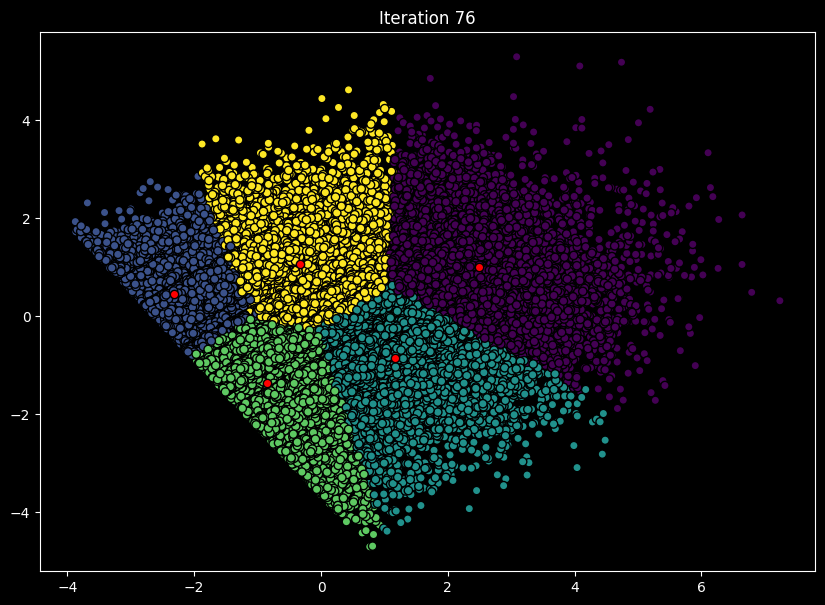

In [19]:
max_iterations = 200
K = 5 # число кластеров(и центроидов)

centroids = random_centroids(data, K)
old_centroids = pd.DataFrame()
iteration = 1

while iteration < max_iterations and not centroids.equals(old_centroids):
    old_centroids = centroids
    
    labels = get_labels(data, centroids)
    centroids = new_centroids(data, labels, K)
    plot_clusters(data, labels, centroids, iteration)
    iteration += 1

## Интерпретация результатов

In [20]:
# Отсортируем центроиды по возрастанию days_registered и добавим колонки с перцентилями (50%, 25%, 75%)
# для упрощения восприятия и интерпретации данных
sorted_centroids = centroids.T.sort_values(by='days_registered').T
sorted_centroids['50%'] = data.describe().loc['50%'].values
sorted_centroids['25%'] = data.describe().loc['25%'].values
sorted_centroids['75%'] = data.describe().loc['75%'].values
sorted_centroids = sorted_centroids.round(3)

In [21]:
sorted_centroids

1      3      4      2      0    50%    25%    75%
blitz_rating          3.308  5.641  3.989  6.411  5.689  5.029  3.946  6.078
blitz_games           1.057  1.122  1.227  1.422  1.595  1.122  1.024  1.383
play_time_total_days  1.077  1.131  1.302  1.499  1.760  1.196  1.059  1.488
days_registered       1.508  1.621  3.476  3.494  5.641  2.925  1.718  3.955
bullet_games          1.014  1.038  1.073  1.185  1.250  1.006  1.000  1.075
puzzle_games          1.016  1.021  1.044  1.061  1.087  1.005  1.000  1.034
rapid_games           1.030  1.023  1.083  1.052  1.103  1.005  1.000  1.042
classical_games       1.005  1.003  1.017  1.010  1.026  1.000  1.000  1.002

In [22]:
# распределение пользователей по кластерам:
labels.value_counts()

4    7301
3    7278
1    7081
2    7045
0    5259
Name: count, dtype: int64

### Интерпретация кластеров
На основе данных кластеризации мы можем проанализировать пять кластеров игроков в шахматы. Основные особенности каждого кластера можно рассматривать в контексте активности и рейтинга игроков в режиме blitz и других режимах, а также общего времени, проведённого в игре.

- Кластер 1:

Игроки этого кластера демонстрируют самый низкий blitz-рейтинг (3.308) и имеют самый короткий срок регистрации (1.508 days_registered), что ниже 25% квартиля. Их результаты в blitz ниже среднего, а количество сыгранных игр также небольшое. Эти игроки могут быть начинающими, которые только начинают осваивать платформу и накапливать опыт. 

- Кластер 3:

Показатель days_registered 1.621 немногим выше чем у игроков 1-го кластера.
blitz_rating (5.641) — несмотря на короткий период регистрации и небольшое количество сыгранных партий (blitz_games = 1.122), они демонстрируют высокий рейтинг, что может говорить о быстром обучении или наличии опыта в шахматах вне платформы.
Также это может указывать на то, что эти игроки обладают высоким уровнем мастерства, так как они быстро поднимают свой рейтинг, что часто наблюдается у опытных игроков, которые создают новые аккаунты. Возможно среди них могут содержаться и новички с высоким потенциалом. Стоит отметить, что игроки в этом кластере меньше всего играют в рапид и классику (1.023 и 1.003); эти показатели даже ниже, чем в первом кластере.

- Кластер 4:

days_registered (3.476) — игроки зарегистрированы примерно столько же, сколько и кластер 2, но их поведение отличается.
play_time_total_days (1.302) — время, проведённое в игре, меньше кластера 2 (1.499), игроки кластера 2 более активные.
blitz_rating (3.989) ближе к с нижним значениям.
Довольно активно играют в rapid, значения rapid_games и classical_games выше чем у кластера 2.
Вероятно, этт кластер отражает средний уровень игроков любителей, которые накапливают опыт, но пока не достигли высоких показателей. 

- Кластер 2:

days_registered (3.494) — игроки, зарегистрированные давно, примерно столько же, сколько и кластер 4, но не так давно, как кластер 0.
blitz_rating (6.411) — это кластер с наивысшим рейтингом, что свидетельствует о том, что это наиболее сильные и квалифицированные игроки.
blitz_games (1.422) — они сыграли меньше игр, чем игроки из кластера 0, но достаточно для поддержания высокого уровня мастерства.
Это, вероятно, наиболее сильные игроки, которые регулярно играют и показывают высокий уровень. В их статистике также выделяется хорошая активность в других режимах, что говорит о разносторонности и высоком мастерстве.

- Кластер 0:

days_registered (5.641) — это игроки, зарегистрированные дольше всего. Они значительно дольше всех находятся на платформе.
blitz_rating (5.689) — их рейтинг ближе к верхним квартилям (75%), что говорит об уровне мастерства выше среднего.
blitz_games (1.595), bullet_games (1.250) — они сыграли больше всего игр в blitz и bullet среди всех кластеров, что говорит о высокой активности.
play_time_total_days (1.760) — они также имеют самое продолжительное общее игровое время.
Этот кластер можно рассматривать как стабильных опытных игроков, которые активно играют и имеют высокий уровень рейтинга. Эти игроки, возможно, ветераны платформы, которые уже достигли высокого уровня мастерства и продолжают активно играть, поддерживая свои результаты.

**Заключение:**
- Кластер 3, вероятно, содержит повторные аккаунты, что объясняет их высокие результаты за короткий срок. Также среди них могут быть новички с потенциалом, которые быстро набирают рейтинг.
- Кластер 1, скорее всего, представляет настоящих новичков, которые только начинают развиваться.
- Кластер 0 включает опытных игроков, которые особенно выделяются количеством дней с момента регистрации, эти игроки, возможно, ветераны платформы.
- Кластер 4 - игроки-любители, которые активнее новичков и зарегистрированы дольше, но не преуспели значительно в уровне игры.
- Кластер 2 — это наиболее сильные и квалифицированные игроки.

Эти результаты могут использоваться для сегментации пользователей по их активности и уровню опыта, что может быть полезно для разработки стратегий взаимодействия с разными группами игроков.
